# Titanic: Machine Learning from Disaster

+ 了解比赛的背景知识，了解各个特征的含义，初步设想特征与预测目标的联系


+ 基础模型
  + 载入数据
  + 观察数据
  + 处理数据
    + 处理缺失值
    + 处理非数值型特征
      + Sex列的处理
      + Embarked列的处理
  + 构建模型
      + 用线性回归和CV拟合模型
       + 计算预测错误率
      + logistic回归
  + 生成结果
      + 处理测试集数据
      + 生成提交结果
      
      
+ 改进预测结果
  + 改进模型
      + 随机森林
       + 调节参数
  + 生成新特征
      + 家庭成员数、姓名长度
      + 头衔
      + 家庭编号
      + 特征选择
  + 模型融合
      + Gradient boosting
  + 生成结果
	   + 处理测试集数据
	   + 对测试集进行预测
	   + 生成提交文件
       
       
+ 最终的思考

In [1]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 了解比赛的背景知识，了解各个特征的含义，初步设想特征与预测目标的联系

+ PassengerId -- A numerical id assigned to each passenger.
+ Survived -- Whether the passenger survived (1), or didn't (0). We'll be making predictions for this column.
+ Pclass -- The class the passenger was in -- first class (1), second class (2), or third class (3).
+ Name -- the name of the passenger.
+ Sex -- The gender of the passenger -- male or female.
+ Age -- The age of the passenger. Fractional.
+ SibSp -- The number of siblings and spouses the passenger had on board.
+ Parch -- The number of parents and children the passenger had on board.
+ Ticket -- The ticket number of the passenger.
+ Fare -- How much the passenger paid for the ticker.
+ Cabin -- Which cabin the passenger was in.
+ Embarked -- Where the passenger boarded the Titanic.

# 基础模型

## 载入数据

In [2]:
titanic = pd.read_csv('./train.csv')

## 观察数据

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 处理数据

### 处理缺失值
fillna方法

In [6]:
_ = titanic.Age.fillna(titanic.Age.median(), inplace=True) # 暂时用中位数填充缺失值

### 处理非数值型特征

到目前为止，有Name, Sex, Cabin, Embarked, Ticket这5列非数值型特征。其中cabin缺失值太多，Ticket和Name这两列暂时没有发现能够带来何种领域知识，因此这三列先不做处理。

+ Sex列的处理

In [7]:
# df.iloc - 支持整数索引 df.loc - 只支持标签索引 df.ix - 整数索引和标签索引都支持，但是在整数索引时会混淆，到底是面向位置还是面向标签
titanic.ix[titanic["Sex"] == "female", "Sex"] = 1 # titanic.loc[titanic["Sex"] == "female", "Sex"] = 1
titanic.ix[titanic["Sex"] == "male", "Sex"] = 0 # titanic.loc[titanic["Sex"] == "male", "Sex"] = 0

+ Embarked列的处理

In [8]:
titanic["Embarked"].unique() # 观察Embarked列的值
titanic.ix[titanic['Embarked'].isnull(), 'Embarked'] = 'S'
titanic.ix[titanic['Embarked'] == 'S', 'Embarked'] = 0
titanic.ix[titanic['Embarked'] == 'C', 'Embarked'] = 1
titanic.ix[titanic['Embarked'] == 'Q', 'Embarked'] = 2

## 构建模型

### 用线性回归和CV拟合模型

In [9]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.cross_validation import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm class
alg = LinearRegression()
# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = titanic["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


+ 计算预测错误率

In [10]:
import numpy as np

# The predictions are in three separate numpy arrays.  Concatenate them into one.  
# We concatenate them on axis 0, as they only have one axis.
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0

accuracy = (predictions == titanic["Survived"]).mean()
print accuracy

0.783389450056


### logistic回归

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation

# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print scores.mean()

0.787878787879


## 生成结果

### 处理测试集数据

In [12]:
titanic_test = pd.read_csv('test.csv')
_ = titanic_test['Age'].fillna(titanic_test['Age'].median(), inplace = True)
titanic_test.loc[titanic_test['Sex'] == 'male', 'Sex'] = 0
titanic_test.loc[titanic_test['Sex'] == 'female', 'Sex'] = 1
_ = titanic_test['Embarked'].fillna('s', inplace = True)
titanic_test.loc[titanic_test['Embarked'] == 'S', 'Embarked'] = 0
titanic_test.loc[titanic_test['Embarked'] == 'C', 'Embarked'] = 1
titanic_test.loc[titanic_test['Embarked'] == 'Q', 'Embarked'] = 2
_ = titanic_test['Fare'].fillna(titanic_test['Fare'].median(), inplace = True)

### 生成提交结果

In [13]:
# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

# 改进预测结果
+ Use a better machine learning algorithm.
+ Generate better features.
+ Combine multiple machine learning algorithms.

## 改进模型

### 随机森林

In [14]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

print scores.mean()

0.801346801347


In [15]:
alg.fit(titanic[predictors], titanic["Survived"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [16]:
alg.feature_importances_

array([ 0.0947804 ,  0.27493029,  0.24973985,  0.04436822,  0.04085351,
        0.26367417,  0.03165354])

+ 调节参数

In [17]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

print scores.mean()

0.820426487093


## 生成新特征

### 家庭成员数、姓名长度

In [18]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].map(lambda x: len(x))

### 头衔

In [19]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].map(get_title)
print pd.value_counts(titles)

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8,
                 "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}

titanic['Title'] = titles.map(title_mapping)

# Verify that we converted everything.
print pd.value_counts(titanic["Title"])

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Title, dtype: int64


### 家庭编号
由姓氏和家庭成员构成，再予以数字编号

In [20]:
# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = max(family_id_mapping.values()) + 1
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print pd.value_counts(family_ids)

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


### 特征选择

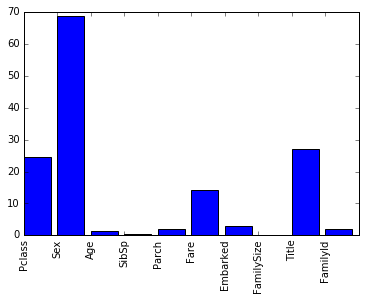

In [21]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [22]:
# 挑选出得分最高的4个特征
predictors = ["Pclass", "Sex", "Fare", "Title"]

# 用随机森林建模
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

# 用3折CV计算正确率
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

print scores.mean()

0.811447811448


## 模型融合

### Gradient boosting
+ Generally, the more diverse the models we ensemble, the higher our accuracy will be.
 + Diversity means that the models generate their results from different columns, or use a very different method to generate predictions.
+ The classifiers we use have to be about the same in terms of accuracy. Ensembling one classifier that is much worse than another probably will make the final result worse.
+ In this case, we'll ensemble logistic regression trained on the most linear predictors (the ones that have a linear ordering, and some correlation to Survived), and a gradient boosted tree trained on all of the predictors.

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = (predictions == titanic["Survived"]).mean()
print accuracy

0.819304152637


## 生成结果

### 处理测试集数据

In [24]:
titanic_test = pd.read_csv('test.csv')
_ = titanic_test['Age'].fillna(titanic_test['Age'].median(), inplace = True)
titanic_test.loc[titanic_test['Sex'] == 'male', 'Sex'] = 0
titanic_test.loc[titanic_test['Sex'] == 'female', 'Sex'] = 1
_ = titanic_test['Embarked'].fillna('s', inplace = True)
titanic_test.loc[titanic_test['Embarked'] == 'S', 'Embarked'] = 0
titanic_test.loc[titanic_test['Embarked'] == 'C', 'Embarked'] = 1
titanic_test.loc[titanic_test['Embarked'] == 'Q', 'Embarked'] = 2
_ = titanic_test['Fare'].fillna(titanic_test['Fare'].median(), inplace = True)

# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8,
                 "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
titanic_test['Title'] = titles.map(title_mapping)

# Check the counts of each unique title.
print pd.value_counts(titanic_test["Title"])

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# The .apply method generates a new series
titanic_test["NameLength"] = titanic_test["Name"].map(lambda x: len(x))

# Now we can add family ids.
# We'll use the same ids that we did earlier.

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64


### 对测试集进行预测

In [25]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int) # 最终必须转化为int，否则kaggle会判罚0分

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

### 生成提交文件

In [26]:
submission.to_csv("titanic_dataquest_test.csv", index=False)

# 最终的思考

+ There's still more work you can do in feature engineering:
 + Try using features related to the cabins.
 + See if any family size features might help -- do the number of women in a family make the whole family more likely to survive?
 + Does the national origin of the passenger's name have anything to do with survival?


+ There's also a lot more we can do on the algorithm side:
 + Try the random forest classifier in the ensemble.
 + A support vector machine might work well with this data.
 + We could try neural networks.
 + Boosting with a different base classifier might work better.

+ And with ensembling methods:
 + Could majority voting be a better ensembling method than averaging probabilities?